# ASTRA Wrapper — Usage Guide
This notebook introduces the ASTRA geometric operator wrapper used in ChestXsim to perform forward projection, backprojection, and reconstruction outside the full simulation pipeline.

Here we focus on direct operator use, allowing you to call ASTRA routines from ChestXsim. The ASTRA wrapper is a concrete implementation of the geometric operator interface, backed by the ASTRA Toolbox for a given Geometry. All ASTRA operators (ASTRA_Tomo, ASTRA_CBCT, ASTRA_FANBEAMCT, ASTRA_PARALLELCT2D) implement the same interface:
- `project(volume, voxel_size)`  wraps  `FP3D_CUDA`  
- `backproject(sino,reco_dim, reco_vx)` wraps  `BP3D_CUDA`
- `reconstruct(method, sino, reco_dim, reco_vx, options…)`  

This guide shows how to:
- create operators for different modalities (DCT, CBCT, 2D CT),
- run manual projection, backprojection, and [ASTRA reconstruction algorithms](https://astra-toolbox.com/docs/algs/index.html)
- use FDK, FBP, and iterative algorithms with the same interface.

Start by loading the attenuation volume

In [1]:
from chestxsim.io import RawReader
from pathlib import Path 
reader = RawReader()
base_path= Path(r"D:\bhermosi\chestxsim-project\results\CT_converted")
case_id = "NODULO_S18_S20"
att_data = reader.read( base_path/ "mus"/ case_id)

# get volume as array and dim from metadata

att_vol = att_data.volume[:, :, :, 0]          # (X, Y, Z)
vx_xyz    = att_data.metadata.voxel_size       # (vx, vy, vz)
print("Input voxel size:", vx_xyz)

GPU detected: Using CuPy with 1 device(s), current device: 0
Input voxel size: (0.84, 0.84, 1.25)


### Tomosynthesis / DCT Example

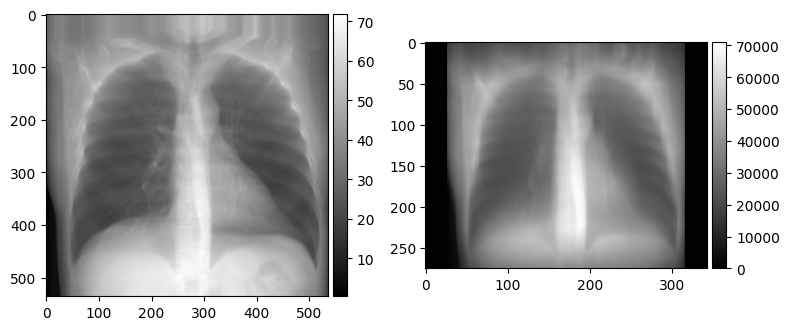

In [2]:
from chestxsim.wrappers.astra import *
from chestxsim.core import TomoGeometry
from chestxsim.utility import plot 

# Define the tomosynthesis system geometry
geo = TomoGeometry(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step_mm=16.077,
    nprojs=60
)
vx_xyz = (0.84, 0.84, 1.25)
# Create the ASTRA operator for DCT 
tomo_opt= ASTRA_Tomo(geometry=geo)

# Forward projection
projs = tomo_opt.project(att_vol, vx_xyz)


# Backprojection
reco_dim_xyz = (344, 86, 276)
reco_vx_xyz  = (1.25, 5.00, 1.25)
backproj = tomo_opt.backproject(projs, reco_dim_xyz, reco_vx_xyz)

plot(projs[:,:,30].T.get(), backproj[:,50,:].T.get())


note the backprojection is blurred, FDK astra implementation is not supported for non isotropic voxels so it can no be directly applied for DCT tomosyntheis: giving the following error:AstraError: Unable to initialize algorithm: Configuration error in CUDA_FDK. Voxels must be cubes for FDK

In [ ]:

# fdk = tomo_opt.reconstruct(
#     "FDK_CUDA",
#     projs,
#     reco_dim_xyz, 
#     reco_vx_xyz,
#     options={"FilterType": "Ram-Lak"} ) 


### CBCT Example — ASTRA Reconstructions

Running forward projection...
Projection completed. Shape: (536, 536, 360)
Running backprojection...
Backprojection completed. Shape: (512, 351, 436)


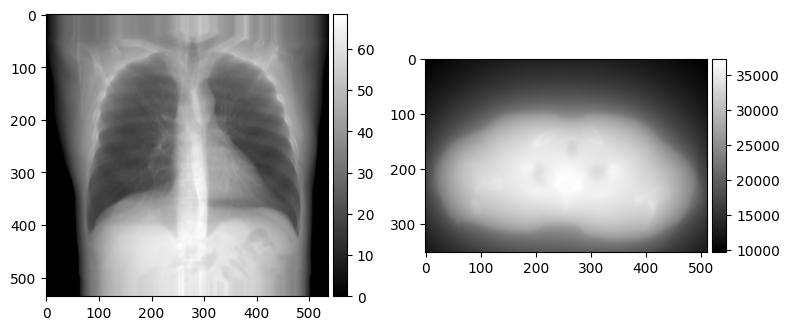

Running FDK reconstruction (FDK_CUDA)...
FDK completed. Shape: (512, 351, 436)
Running SIRT reconstruction (150 iterations)...
SIRT completed. Shape: (512, 351, 436)
Backprojection vs FDK  vs SIRT ASTRA RECONSTRUCTIONS


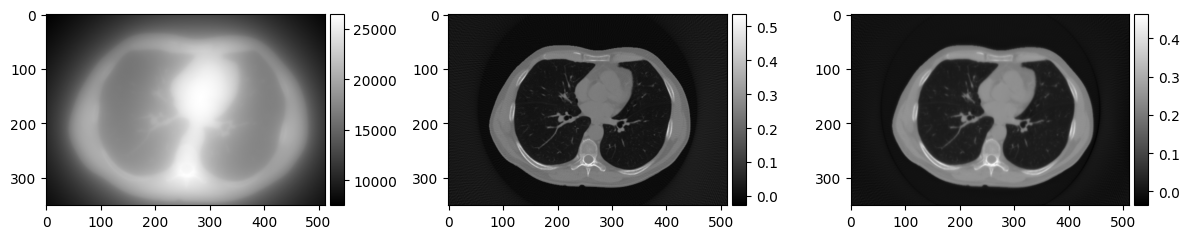

In [4]:
from chestxsim.wrappers.astra import ASTRA_CBCT
from chestxsim.core.geometries import CBCTGeometry
from chestxsim.utility import plot

# Define CBCT system geometry
geo = CBCTGeometry(
    detector_size=[4288, 4288],
    pixel_size=[0.1, 0.1],   # mm
    binning_proj=8,
    SDD=1800,
    DOD=100,
    nprojs=360,
    step_angle=1.0,
    init_angle=0.0,
)

# Create ASTRA CBCT operator
cbct_op = ASTRA_CBCT(geometry=geo)

# Forward projection
print("Running forward projection...")
projs = cbct_op.project(att_vol, vx_xyz)
print("Projection completed. Shape:", projs.shape)

# Adjoint / simple backprojection
reco_dim_xyz = att_vol.shape
reco_vx_xyz  = vx_xyz

print("Running backprojection...")
backproj = cbct_op.backproject(projs, reco_dim_xyz, reco_vx_xyz)
print("Backprojection completed. Shape:", backproj.shape)

# Quick visual check
plot(
    projs[:, :, 0].T.get(),
    backproj[:, :, 100].T.get(),
)

# ASTRA reconstructions (requires isotropic voxels)
vx_iso = (1.0, 1.0, 1.0)

# FDK reconstruction
print("Running FDK reconstruction (FDK_CUDA)...")
fdk = cbct_op.reconstruct(
    "FDK_CUDA",
    projs,
    reco_dim_xyz,
    vx_iso,
    options={"FilterType": "Ram-Lak"},
)
print("FDK completed. Shape:", fdk.shape)

# SIRT reconstruction
print("Running SIRT reconstruction (150 iterations)...")
sirt = cbct_op.reconstruct(
    "SIRT3D_CUDA",
    projs,
    reco_dim_xyz,
    vx_iso,
    iterations=150,
)
print("SIRT completed. Shape:", sirt.shape)

# Final axial slice comparison
slice_z = fdk.shape[2] // 2
print("Backprojection vs FDK  vs SIRT ASTRA RECONSTRUCTIONS")
plot(
    backproj[:, :, slice_z].T.get(),
    fdk[:, :, slice_z].T.get(),
    sirt[:, :, slice_z].T.get()

    
)


### 2D Fan-beam & Parallel-beam CT Examples

Running 2D fan-beam forward projection...
Fan-beam projection completed. Shape: (360, 536)
Running 2D fan-beam backprojection...
Fan-beam backprojection completed. Shape: (512, 351)
Running 2D fan-beam FBP reconstruction (FBP_CUDA)...
Fan-beam FBP completed. Shape: (512, 351)


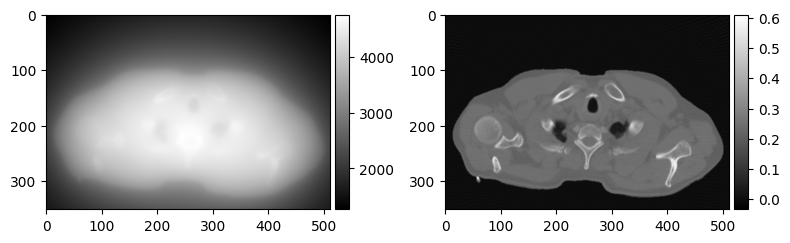

In [6]:
from chestxsim.wrappers.astra import ASTRA_FANBEAMCT
from chestxsim.core.geometries import CT2DFanGeometry
from chestxsim.utility import plot

# Input 2D image and pixel spacing
i= 100
input_img = att_vol[:,:,i]             # shape: (X, Y)
px_xy     = (0.5, 0.5)                 # (vx, vy) in mm

# Define fan-beam geometry
fan_geom = CT2DFanGeometry(
    detector_size=[4288],
    pixel_size=[0.1],    # mm
    binning_proj=8,
    SDD=1800,
    DOD=100,
    nprojs=360,
    step_angle=1.0,
    init_angle=0.0,
)

# Create ASTRA fan-beam operator
fan_op = ASTRA_FANBEAMCT(fan_geom)

# Forward projection
print("Running 2D fan-beam forward projection...")
projs_fan = fan_op.project(input_img, px_xy)   # shape: (Angles, Detectors)
print("Fan-beam projection completed. Shape:", projs_fan.shape)

# Backprojection
print("Running 2D fan-beam backprojection...")
backproj_fan = fan_op.backproject(projs_fan, input_img.shape, px_xy)
print("Fan-beam backprojection completed. Shape:", backproj_fan.shape)

# FBP reconstruction (fan-beam)
print("Running 2D fan-beam FBP reconstruction (FBP_CUDA)...")
fbp_fan = fan_op.reconstruct(
    "FBP_CUDA",
    projs_fan,
    input_img.shape,
    px_xy,
    options={"FilterType": "Ram-Lak"},
)
print("Fan-beam FBP completed. Shape:", fbp_fan.shape)

# Slice comparison (2D image)
plot(
    backproj_fan.T.get(),
    fbp_fan.T.get(),
  
)
